# How to Clean up a Dataset

![Baby Bunny](img/kit.jpeg)

## Load Libraries

In [6]:
%matplotlib inline
#generic imports
import csv
import notebook as nb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import json
import sys
import inspect
import math
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
from sklearn.utils import shuffle

import random

dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe()))) # script directory

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


You have some example documents with classifications and you want to increase the accuracy of predictions you make with this dataset. This is a workshop to find issues in a dataset with python. 

We use a bunny farm chatbot. But sentiment analysis, news, email classification or any supervised learning dataset will have similar issues.

## Bashful Bunnies

A pet rabbit seller on facebook wants to answer common customer questions while they are offline. They give you previous questions they have been asked. And you help them label these by Topic_Verb. This is a whole other talk.

Now you want to quickly go through these labels to find mistakes. Usually 500 questions in 20-50 intents. 

# Tasks
<input type="checkbox"> Load Libraries
<input type="checkbox"> Load Data
<input type="checkbox"> Language specific stuff (spelling, accents, segment words in Chinese etc)
<input type="checkbox"> Run KFold test
<input type="checkbox"> Save Data to show improvements
<input type="checkbox"> Graph questions, Intents and Accuracy
<input type="checkbox"> Find Duplicates
<input type="checkbox"> Find Wrongly labeled
<input type="checkbox"> Find Double Categories
<input type="checkbox"> Find Nonsense
<input type="checkbox"> Find Bad intents
<input type="checkbox"> Look at confusion Matrix
<input type="checkbox"> Label new data 


## Load Data

First off load the data. The file needs to be this name, type and in he local directory. And in the format Question, Intent with a header

In [15]:
filePath = r'bunny.csv'
df = pd.read_csv(filePath,header=0,encoding='utf-8')
df.head()

,Question,Intent
0,Are the baby rabbits certified?,RABBIT_CERTIFICATION
1,What cert does the kit have?,RABBIT_CERTIFICATION
2,Does the rabbit have a certificate? And what f...,RABBIT_CERTIFICATION
3,Is the kit certified by a vet?,RABBIT_CERTIFICATION
4,Has the kit been cleared by a vet?,RABBIT_CERTIFICATION


Ground Truth is utterence (question), intent

  - Real questions from real users
  - Topic_Verb the utterences
 
 10 topics, 50 intents, 2000 Questions but this process here with 500.

# Start Analysis

## Make Kfolds

Make a classifier and get it to classify every quesstion in the training data. 

What it gets wrong we look at to see if our original classificationw as wrong.

In [16]:
#Make five folds
#shuffle the data
df = shuffle(df, random_state=0)
df = df.dropna()
numFolds=5
size=math.trunc(len(df)/numFolds)
#MAke the flds 5 folds
Fold1=df[:size]
Fold2=df[size:(size*2)]
Fold3=df[(size*2):(size*3)]
Fold4=df[(size*3):(size*4)]
Fold5=df[(size*4):]

### now we have folds define a classifier

In [8]:


text_clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2) )),#,stop_words=stopWords ngram_range=(1, 1)
                    ('clf',  SGDClassifier(loss='modified_huber', penalty='l2',alpha=1e-3, tol=0.001, max_iter=1000, random_state=42)),#n_iter=20 'hinge'
                    #('clf',  MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)),
                    ]) 


In [18]:
#This is what makes train smaller
train = pd.concat([Fold2, Fold3, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)


df1 = pd.DataFrame(columns=['Question', 'GTIntent', 'Prediction 1','Conf 1','Pred2','conf2','match'])

total=0


def runFold(test):
    i=0
    global total,df1

    for row in test.iterrows():
        row2=[test.iloc[i,0]]
        #row2=[row]
        predicted=text_clf.predict(row2)
        values= text_clf.predict_proba(row2)
        best_n = np.argsort(values, axis=1)[:,-3:]
    
        if test.iloc[i,1]==predicted[0]:
                match=1
                total=total+1
        else:
                match=0
            

        df1 = df1.append({'Question' : row2[0] , 'GTIntent' : test.iloc[i,1],'Prediction 1':text_clf.classes_[best_n.item(2)],'Conf 1':math.trunc(values[0][best_n.item(2)]*100),'Pred2':text_clf.classes_[best_n.item(1)],'conf2':math.trunc(values[0][best_n.item(1)]*100),'match':match} , ignore_index=True)#,'':,'':,'':,'':,'':


        i=i+1

        
train = pd.concat([Fold2, Fold3, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold1)
train = pd.concat([Fold1, Fold3, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold2)
train = pd.concat([Fold1, Fold2, Fold4,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold3)
train = pd.concat([Fold1, Fold2, Fold3,Fold5]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold4)
train = pd.concat([Fold1, Fold2, Fold3,Fold4]) 
text_clf.fit(train.Question, train.Intent)        
runFold(Fold5)


print("accuracy is "+str(total/(len(Fold1)*5)))
df1.to_excel('checkThese.xlsx', encoding='utf-8', index=False)#



accuracy is 0.5565217391304348


In [178]:
## save data in a csv 
## Date, Accuracy, intent numbers, question numbers
import datetime as dt
now=dt.datetime.today().strftime("%m/%d/%Y")

with open("result_statistics.csv", "a") as myfile:
    myfile.write(now+","+str(df['Intent'].nunique())+","+str(len(df))+","+str(math.trunc((total/(len(Fold1)*5)*100)))+"\n")    

In [179]:

#date,intents,questions,accuracy
filePath = r'result_statistics.csv'
plotdata = pd.read_csv(filePath,header=0)

#df = df.iloc[1:]
plotdata.head()

,date,intents,questions,accuracy
0,10/03/2019,2,13000,70
1,10/07/2019,3,500,67
2,10/07/2019,3,404,66
3,10/07/2019,3,320,65
4,10/07/2019,3,504,70


## Make graphs

## Accuracy of intents graphs and tables

In [91]:
colors=[]
when = plotdata.iloc[:,0]
#make a random list of colors
for i in enumerate(when):
    nextC=random(),random(),random()
    colors.append(nextC)
    
   

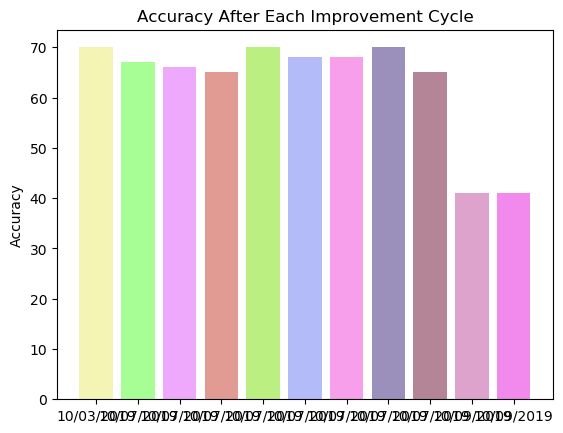

In [92]:
when = plotdata.iloc[:,0]
performance = plotdata.iloc[:,3]

y_pos = np.arange(len(when))
plt.bar(y_pos, performance, align='center', alpha=0.5, color=colors)


plt.xticks(y_pos, when)
plt.ylabel('Accuracy')
plt.title('Accuracy After Each Improvement Cycle')



plt.savefig('AccuracyExamplesOct02.png')
plt.savefig('AccuracyExamplesOct02.pdf')

![rabbit eating](img/coco2.jpg)

## Find Errors

Three kinds of errors
Duplicates
Confident and wrong
second cofidence wrong
low confidence nonesense

In [19]:
df1.tail()

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
110,I will buy the kit if you let me veterianian s...,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,1
111,has the kit had to go see a vet?,RABBIT_HEALTH,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,1
112,Did the rabbit have to visit a vet?,RABBIT_HEALTH,RABBIT_HEALTH,100,RABBIT_SOCIALISATION,0,1
113,Do you verify that the kit does not have fleas?,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,1
114,Can you guarantee the rabbit doesn't have worms?,RABBIT_HEALTH,RABBIT_SOCIALISATION,11,RABBIT_PARENTS,11,0


In [20]:
dupes = pd.DataFrame()
dupes=df[df.duplicated('Question', keep=False)]
dupes = dupes.sort_values('Question',ascending=False)
#dupes.to_html('dupes.html', encoding='utf-8')

htmld = dupes.to_html()
#with open("dupes.html", "w", encoding="utf-8") as file:
#    file.write(html)
    

Empty DataFrame
Columns: [Question, Intent]
Index: []


![dog](img/dog.jpg) 

In [21]:
#Find high confidence wrong
highWrong = df1[(df1['Conf 1'] > 95) & (df1['match'] ==0)]
highWrong=highWrong.sort_values(by=['Conf 1'],ascending=False)

htmlhw = highWrong.to_html()
#with open("highWronguestions.html", "w", encoding="utf-8") as file:
#    file.write(html)
    

![two at once](img/maxresdefault.jpg) 

In [22]:
#Find intents where second intent is high confidence

doubleq = df1[df1.conf2 > 45]
doubleq=doubleq.sort_values(by=['conf2'],ascending=False)
htmldq = doubleq.to_html()
#with open("doublequestions.html", "w", encoding="utf-8") as file:
#    file.write(html)
    
    

Why two questions at once?
  -  Customers see one task when business sees two. 'I want to cancel my card and get a new one'
  -  People complain about two things at once. 'The food is terrible and the portions are too small'
  -  Chatbot is not clear enough to ask one question at a time. This is the big reason to admit you are a chatbot
  -  Just asked two questions when they shouldnt have

![rabbit eating](img/0000049339.jpg)

In [23]:
#Find intents that are low confidence and wrong. Might be nonsense

verylow = df1[(df1['Conf 1'] < 10) & (df1['match'] ==0)]
verylow=verylow.sort_values(by=['conf2'],ascending=False)
dflc = verylow.to_html()
#df.to_html('filename.html')

#with open("lowconf.html", "w", encoding="utf-8") as file:
#    file.write(html)

In [24]:
with open("all.html", 'w') as _file:
    _file.write( "<h1>Duplicates</h1>"+htmld + "\n\n<h1>Double Questions</h1>" + htmldq+ "\n\n<h1>High Confidence Wrong</h1>"+ htmlhw+ "\n\n<h1>Could be Nonsense</h1>"+ dflc)

## Find bad intents

![rabbit eating](img/bunny2.jpg)

![Low and right should be looked at](img/fixthese2.png)


In [25]:
wrong = df1[(df1['GTIntent']!=df1['Prediction 1'])]
correct = df1[(df1['GTIntent']==df1['Prediction 1'])]

wf=wrong.groupby(['GTIntent'], as_index=False).count()
crf=correct.groupby(['GTIntent'], as_index=False).count()
gf1=wf[['GTIntent','Question']]
gf1.columns = ['Intent', 'wrong']


crf1=crf[['GTIntent','Question']]
crf1.columns = ['Intent', 'right']
crf1.head()
result = pd.merge(crf1,gf1,on='Intent',how='outer')
result=result.fillna(0)
#calculate percentage we got right
result['percent'] = (result['right']/(result['wrong'] + result['right']))*100
#total questions
result['total'] = result['wrong'] + result['right']
result=result.round(0)

In [26]:
lowAcc = result[(result.percent < 100) & (result['wrong'] >1)]
lowAcc=lowAcc.sort_values(by=['total'],ascending=False)
lowAcc

,Intent,right,wrong,percent,total
4,RABBIT_HEALTH,22.0,22,50.0,44.0
5,RABBIT_PARENTS,11.0,3,79.0,14.0
0,BREEDER_INFORMATION,4.0,8,33.0,12.0
2,PURCHASE_RABBIT,4.0,5,44.0,9.0
6,RABBIT_SOCIALISATION,7.0,2,78.0,9.0
3,RABBIT_CERTIFICATION,2.0,6,25.0,8.0
1,BREEDER_REFERENCES,2.0,5,29.0,7.0
7,BREEDER_GUARANTEE,0.0,6,0.0,6.0
8,RABBIT_FOOD,0.0,6,0.0,6.0


## Confusion Matrix

In [57]:
df1.head()

,Question,GTIntent,Prediction 1,Conf 1,Pred2,conf2,match
0,Do I need to get the rabbit neutered?,RABBIT_LIMITED_REGISTRATION,RABBIT_VET_VISITS,5,RABBIT_CERTIFICATION,5,0
1,Am I able to return the kit?,BREEDER_GUARANTEE,RABBIT_VET_VISITS,5,RABBIT_CERTIFICATION,5,0
2,What has the baby rabbits been fed?,RABBIT_FOOD,RABBIT_VET_VISITS,5,RABBIT_CERTIFICATION,5,0
3,What rabbit food brand do you use?,RABBIT_FOOD,RABBIT_VET_VISITS,5,RABBIT_CERTIFICATION,5,0
4,Was the rabbit well treated when being raised?,RABBIT_SOCIALISATION,RABBIT_HEALTH,100,RABBIT_VET_VISITS,0,0


In [27]:


def get_confusion_matrix(y_true, y_pred, labels, normalize=False):
    conf_matrix = metrics.confusion_matrix(y_true, y_pred, labels)
    if normalize:
        conf_matrix = conf_matrix.astype('float')/conf_matrix.sum(axis=1)[:, np.newaxis]
    conf = pd.DataFrame(conf_matrix, index=labels, columns=labels)
    return conf

In [29]:
conf=df1#res[0]
cf = get_confusion_matrix(conf['GTIntent'], conf['Prediction 1'], labels=conf['GTIntent'].unique())
#df['Diag'] =pd.Series(np.diag(cf), index=[cf.index, cf.columns])
cf.tail()

conf = cf.to_csv('Confusion.csv', encoding='utf-8')

## Label Data

![rabbit eating](img/baby-bunny.jpg)

In [74]:
filePath = r'tolabel.csv'

label = pd.read_csv(filePath,header=0)

#label=label.drop(['Unnamed: 0'], axis=1)
label = label.dropna()        
label.head(20)


,Question,Intent
0,Are the baby rabbits certified?,RABBIT_CERTIFICATION
1,What cert does the kit have?,RABBIT_CERTIFICATION
2,Does the rabbit have a certificate?,RABBIT_CERTIFICATION
3,Is the kit certified by a vet?,RABBIT_CERTIFICATION
4,Has the kit been cleared by a vet?,RABBIT_CERTIFICATION
5,Has a vet certified the rabbit ?,RABBIT_CERTIFICATION
6,Do rabbits need a health cert,RABBIT_CERTIFICATION
7,Do rabbits get health documentation,RABBIT_CERTIFICATION
8,Do rabbits have parental bloodlines?,RABBIT_PARENTS_INFORMATION
9,Are the breeds of the rabbits parents?,RABBIT_PARENTS_INFORMATION


In [95]:
#train = pd.concat([trainSent]) 
text_clf.fit(df.Question, df.Intent)        


Pipeline(memory=None,
     steps=[('vect', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
        strip...om_state=42, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False))])

Label all the new data. And then go through it by intent agreeing or disagreeing with the label

In [96]:
labeled = pd.DataFrame(columns=['Question', 'Prediction 1','Conf 1','Pred2','conf2'])
i=0


for row in label.iterrows():
    row2=[label.iloc[i,0]]
    predicted=text_clf.predict(row2)
    values= text_clf.predict_proba(row2)
    best_n = np.argsort(values, axis=1)[:,-3:]            
    labeled = labeled.append({'Question' : row2[0] ,'Prediction 1':text_clf.classes_[best_n.item(2)],'Conf 1':math.trunc(values[0][best_n.item(2)]*100),'Pred2':text_clf.classes_[best_n.item(1)],'conf2':math.trunc(values[0][best_n.item(1)]*100)} , ignore_index=True)
    i=i+1


In [97]:
labeled.tail()

,Question,Prediction 1,Conf 1,Pred2,conf2
112,I want to buy a kit.,PURCHASE_RABBIT,100,RABBIT_VET_VISITS,0
113,Can I buy a rabbit ?,PURCHASE_RABBIT,100,RABBIT_VET_VISITS,0
114,I am ready to buy your baby rabbits,PURCHASE_RABBIT,100,RABBIT_VET_VISITS,0
115,Please sell me your rabbit,PURCHASE_RABBIT,100,RABBIT_VET_VISITS,0
116,"I love the look of your rabbit , can I buy it.",PURCHASE_RABBIT,100,RABBIT_VET_VISITS,0
